# Wind Farm Spotter - Data Engineering Notebook

## Environment Setup 

In [0]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (123 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 132684 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1b

     |████████████████████████████████| 2.8MB 5.0MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp36-cp36m-linux_x86_64.whl size=3702083 sha256=f56e12d731db981bc5ef052076ab1ed62ebeefd21a57f37227c899991d1d8a0f
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 2.4.1
    Uninstalling pyproj-2.4.1:
      Successfully uninstalled pyproj-2.4.1


#### (Basemap Patch)

In [0]:
with open('/content/patch.txt','r') as writer_file:
    contents_to_write = writer_file.read()
with open('/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/proj.py' ,'w') as file_to_overwrite:
    file_to_overwrite.write(contents_to_write)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
working_dir = "/content/drive/My Drive/dla-project"
data_dir = working_dir + "/data"
tab_data = working_dir + "/tabular_data"

## Imports

In [0]:
%matplotlib inline
import os
import numpy as np
import matplotlib
#for better zoom
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
from IPython.display import Image
from pandas.io.json import json_normalize
import json

## US Wind Turbine Database 

In [0]:
turbine_data = pd.read_csv(tab_data + "/uswtdb_v2_1_20190715.csv")
print(turbine_data.columns)

Index(['case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 't_state', 't_county',
       't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap', 't_manu', 't_model',
       't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh', 't_conf_atr', 't_conf_loc',
       't_img_date', 't_img_srce', 'xlong', 'ylat'],
      dtype='object')


In [0]:
turbine_data.head()

,case_id,faa_ors,faa_asn,usgs_pr_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
0,3000001,NaN,NaN,6569.0,CA,Kern County,6029,Difwind 6,1987.0,250,27.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,11/3/2018,Digital Globe,-118.270027,35.066048
1,3000002,NaN,NaN,2908.0,CA,Kern County,6029,Sky River,1990.0,342,76.95,Vestas,V27,225.0,30.0,27.0,572.56,43.5,2,3,11/28/2017,Digital Globe,-118.237885,35.263294
2,3000003,NaN,NaN,3100.0,CA,Kern County,6029,unknown Tehachapi Wind Resource Area 1,1982.0,1737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,11/3/2018,Digital Globe,-118.299385,35.044796
3,3000005,NaN,NaN,3022.0,CA,Kern County,6029,Sky River,1990.0,342,76.95,Vestas,V27,225.0,30.0,27.0,572.56,43.5,2,3,9/22/2018,Digital Globe,-118.228088,35.200497
4,3000008,NaN,NaN,3463.0,CA,Kern County,6029,unknown Tehachapi Wind Resource Area 1,1982.0,1737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,5/8/2018,Digital Globe,-118.302778,35.078526


In [0]:
turbine_data.case_id.count()

59884

In [0]:
turbine_data = turbine_data[turbine_data['p_cap'].notnull()]
turbine_data.head()

,case_id,faa_ors,faa_asn,usgs_pr_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
0,3000001,NaN,NaN,6569.0,CA,Kern County,6029,Difwind 6,1987.0,250,27.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,11/3/2018,Digital Globe,-118.270027,35.066048
1,3000002,NaN,NaN,2908.0,CA,Kern County,6029,Sky River,1990.0,342,76.95,Vestas,V27,225.0,30.0,27.0,572.56,43.5,2,3,11/28/2017,Digital Globe,-118.237885,35.263294
3,3000005,NaN,NaN,3022.0,CA,Kern County,6029,Sky River,1990.0,342,76.95,Vestas,V27,225.0,30.0,27.0,572.56,43.5,2,3,9/22/2018,Digital Globe,-118.228088,35.200497
5,3000010,NaN,NaN,16102.0,CA,Riverside County,6065,Alta Mesa 1 and 2,1988.0,115,18.56,Danwin,23_160,160.0,23.0,23.0,415.48,34.5,3,3,11/3/2018,Digital Globe,-116.666191,33.944595
6,3000011,NaN,NaN,5760.0,CA,Kern County,6029,251 Wind,1987.0,194,18.43,Vestas,Unknown Vestas,95.0,NaN,NaN,NaN,NaN,2,3,5/8/2018,Digital Globe,-118.354889,35.085094


In [0]:
turbine_data.case_id.count()

56313

In [0]:
def get_centroid(pt_list):
  sz = len(pt_list)
  if sz > 0:
    pt_acc = 0
    for pt in pt_list:
      #print(pt)
      pt_acc += pt 
    centroid = pt_acc/sz
    return centroid

In [0]:
turbine_projects = turbine_data.groupby('p_name').agg(lambda x: list(x))
turbine_projects["p_cap"] = turbine_projects["p_cap"].apply(lambda x: float(get_centroid(x)))
turbine_projects["p_tnum"] = turbine_projects["p_tnum"].apply(lambda x: int(get_centroid(x)))
turbine_projects["xlong"] = turbine_projects["xlong"].apply(lambda x: get_centroid(x))
turbine_projects["ylat"] = turbine_projects["ylat"].apply(lambda x: get_centroid(x))

In [0]:
len(turbine_projects)

1348

## Existing Turbines Table

In [0]:
turbine_projects

,case_id,faa_ors,faa_asn,usgs_pr_id,t_state,t_county,t_fips,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
p_name,,,,,,,,,,,,,,,,,,,,,,,
251 Wind,"[3000011, 3000691, 3000753, 3001002, 3001247, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[5760.0, 5831.0, 5776.0, 4950.0, 5115.0, 5037....","[CA, CA, CA, CA, CA, CA, CA, CA, CA, CA, CA, C...","[Kern County, Kern County, Kern County, Kern C...","[6029, 6029, 6029, 6029, 6029, 6029, 6029, 602...","[1987.0, 1987.0, 1987.0, 1987.0, 1987.0, 1987....",194,18.43,"[Vestas, Vestas, Vestas, Vestas, Vestas, Vesta...","[Unknown Vestas, Unknown Vestas, Unknown Vesta...","[95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[5/8/2018, 5/8/2018, 5/8/2018, 5/8/2018, 5/8/2...","[Digital Globe, Digital Globe, Digital Globe, ...",-118.359026,35.083407
30 MW Iowa DG Portfolio,"[3049500, 3049502, 3049503, 3049504, 3053390, ...","[19-028030, 19-027953, 19-028064, 19-028019, 1...","[2014-WTE-4080-OE, 2014-WTE-4082-OE, 2014-WTE-...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[IA, IA, IA, IA, IA, IA, IA, IA, IA, IA]","[Story County, Story County, Story County, Pow...","[19169, 19169, 19169, 19157, 19015, 19169, 191...","[2017.0, 2017.0, 2017.0, 2017.0, 2017.0, 2017....",10,30.00,"[Nordex, Nordex, Nordex, Nordex, Nordex, Norde...","[AW125/3000, AW125/3000, AW125/3000, AW125/300...","[3000.0, 3000.0, 3000.0, 3000.0, 3000.0, 3000....","[87.5, 87.5, 87.5, 87.5, 87.5, 87.5, 87.5, 87....","[125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125...","[12271.85, 12271.85, 12271.85, 12271.85, 12271...","[150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[5/13/2017, 5/13/2017, 5/13/2017, 1/28/2017, 6...","[Digital Globe, Digital Globe, Digital Globe, ...",-93.449786,42.006571
6th Space Warning Squadron,"[3046262, 3046335]","[25-025115, 25-025116]","[2013-WTE-5497-OE, 2013-WTE-5773-OE]","[26723.0, 26722.0]","[MA, MA]","[Barnstable County, Barnstable County]","[25001, 25001]","[2013.0, 2013.0]",2,3.36,"[GE Wind, GE Wind]","[GE1.68-82.5, GE1.68-82.5]","[1680.0, 1680.0]","[80.0, 80.0]","[82.5, 82.5]","[5345.62, 5345.62]","[121.3, 121.3]","[3, 3]","[3, 3]","[nan, nan]","[Digital Globe, Digital Globe]",-70.543552,41.753341
AFCEE MMR Turbines,"[3039277, 3039278]","[25-022039, 25-022038]","[2011-WTE-7516-OE, 2011-WTE-7517-OE]","[26676.0, 26677.0]","[MA, MA]","[Barnstable County, Barnstable County]","[25001, 25001]","[2011.0, 2011.0]",2,3.00,"[GE Wind, GE Wind]","[GE1.5-77, GE1.5-77]","[1500.0, 1500.0]","[80.0, 80.0]","[77.0, 77.0]","[4656.63, 4656.63]","[118.6, 118.6]","[3, 3]","[3, 3]","[nan, nan]","[Digital Globe, Digital Globe]",-70.546550,41.758590
AG Land 1,[3035472],[19-022350],[2010-WTE-9312-OE],[21004.0],[IA],[Story County],[19169],[2012.0],1,1.60,[GE Wind],[GE1.6-82.5],[1600.0],[80.0],[82.5],[5345.62],[121.3],[3],[3],[nan],[Digital Globe],-93.325691,42.206390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wynford Local Schools,[3005468],[nan],[nan],[35969.0],[OH],[Crawford County],[39033],[2011.0],2,0.20,[Northern Power Systems],[NW100],[100.0],[37.0],[21.0],[346.36],[47.5],[3],[3],[nan],[Bing Maps Aerial],-83.019592,40.822792
Yahoo Creek,"[3036163, 3036164, 3036378, 3036422, 3036423, ...","[16-020296, 16-020261, 16-020295, 16-021320, 1...","[2010-WTW-14356-OE, 2010-WTW-14357-OE, 2010-WT...","[21458.0, 21460.0, 21455.0, 21451.0, 21453.0, ...","[ID, ID, ID, ID, ID, ID, ID, ID, ID, ID, ID, I...","[Twin Falls County, Twin Falls County, Twin Fa...","[16083, 16083,

### Existing Turbine Projects - Statistical Moments 

In [0]:
turbine_df = turbine_projects[['p_cap', 'p_tnum','xlong', 'ylat']]
turbine_df.describe()

,p_cap,p_tnum,xlong,ylat
count,1348.000000,1348.000000,1348.000000,1348.000000
mean,67.764748,39.555638,-98.568116,40.460719
std,77.238193,45.947638,18.432038,6.065680
min,0.050000,1.000000,-171.711609,13.389381
25%,3.000000,2.000000,-103.649050,36.202441
50%,38.500000,24.000000,-97.693591,41.468815
75%,105.000000,64.000000,-89.596237,43.721807
max,495.010000,460.000000,144.722656,66.839205


## Existing Farms - Class Segmentation 

### Low Capacity Farms 

In [0]:
low_cap_turbines = turbine_df[turbine_df['p_cap'] <= 3]
low_cap_turbines.describe()

,p_cap,p_tnum,xlong,ylat
count,357.000000,357.000000,357.000000,357.000000
mean,1.110474,1.607843,-95.397245,42.983917
std,0.853872,2.644210,26.799198,6.766885
min,0.050000,1.000000,-171.711609,13.389381
25%,0.250000,1.000000,-99.247841,40.903761
50%,0.900000,1.000000,-93.435242,41.834719
75%,1.650000,1.000000,-82.572746,43.916990
max,3.000000,39.000000,144.722656,66.839205


### Medium Capacity Farms 

In [0]:
med_cap_turbines = turbine_df[(turbine_df['p_cap'] > 3) & (turbine_df['p_cap'] <= 105)]
med_cap_turbines.describe()

,p_cap,p_tnum,xlong,ylat
count,656.000000,656.000000,656.000000,656.000000
mean,46.476059,32.240854,-99.839438,40.461087
std,34.011621,36.275451,16.022179,5.359371
min,3.024000,1.000000,-158.041924,17.984863
25%,14.220000,10.000000,-111.765406,36.447147
50%,40.500000,25.000000,-98.951004,41.785150
75%,77.991667,44.000000,-92.448039,43.981656
max,105.000000,460.000000,-65.697051,64.064857


### High Capacity Farms 

In [0]:
high_cap_turbines = turbine_df[turbine_df['p_cap'] > 105]
high_cap_turbines.describe()

,p_cap,p_tnum,xlong,ylat
count,335.000000,335.000000,335.000000,335.000000
mean,180.484019,94.319403,-99.457709,37.771098
std,58.374275,35.691493,9.300648,5.402438
min,105.750000,33.000000,-121.802868,26.192765
25%,140.580000,70.000000,-101.677011,33.590974
50%,167.900000,87.000000,-99.392863,37.489889
75%,201.450000,116.000000,-95.376725,42.105589
max,495.010000,267.000000,-68.101019,48.964765


## Potential Farms - Feature Engineering 

In [0]:
def extract_cords(df):
  vals = pd.Series(df['.geo'].values).map(lambda x: json.loads(x))
  vals_norm = json_normalize(vals).drop('type', axis=1)
  new_df = pd.DataFrame(vals_norm['coordinates'].values.tolist(), columns=['xlong','ylat'])
  return new_df


In [0]:
no_turb_no_pot1 = pd.read_csv(tab_data + "/no_turbines_no_potential.csv")
print(no_turb_no_pot1.head())

   system:index                                               .geo
0             0  {"type":"Point","coordinates":[-95.65702360359...
1             1  {"type":"Point","coordinates":[-95.57266625047...
2             2  {"type":"Point","coordinates":[-95.52183047847...
3             3  {"type":"Point","coordinates":[-95.49927696791...
4             4  {"type":"Point","coordinates":[-94.81398783412...


In [0]:
no_pot_df1 = extract_cords(no_turb_no_pot1)
no_pot_df1.head()

,xlong,ylat
0,-95.657024,38.121267
1,-95.572666,38.133807
2,-95.521830,38.138926
3,-95.499277,38.143293
4,-94.813988,38.142832


In [0]:
no_pot_df1.describe()

,xlong,ylat
count,201.000000,201.000000
mean,-85.966195,39.814950
std,12.309440,2.496299
min,-116.317743,33.606508
25%,-92.615717,37.951070
50%,-84.134402,41.404562
75%,-73.990466,41.813343
max,-71.343878,42.102016


In [0]:
no_turb_no_pot2 = pd.read_csv(tab_data + "/no_cap_no_wind.csv")
print(no_turb_no_pot2.head())

   system:index                                               .geo
0             0  {"type":"Point","coordinates":[-95.02912294625...
1             1  {"type":"Point","coordinates":[-94.76545107125...
2             2  {"type":"Point","coordinates":[-91.99689638375...
3             3  {"type":"Point","coordinates":[-89.22834169625...
4             4  {"type":"Point","coordinates":[-87.82209169625...


In [0]:
no_pot_df2 = extract_cords(no_turb_no_pot2)
no_pot_df2.head()

,xlong,ylat
0,-95.029123,31.777809
1,-94.765451,33.406810
2,-91.996896,33.663223
3,-89.228342,31.515935
4,-87.822092,31.815159


In [0]:
no_pot_df2.describe()

,xlong,ylat
count,45.000000,45.000000
mean,-88.721506,34.141561
std,5.999970,3.257780
min,-99.335764,28.664697
25%,-92.304514,31.328432
50%,-89.228342,33.663223
75%,-84.394357,36.856011
max,-77.626779,40.122727


In [0]:
no_pot_df = pd.concat([no_pot_df1, no_pot_df2]) 

In [0]:
no_pot_df.describe()

,xlong,ylat
count,246.000000,246.000000
mean,-86.470215,38.777135
std,11.458458,3.438529
min,-116.317743,28.664697
25%,-92.537916,37.908792
50%,-85.591549,38.678127
75%,-74.001607,41.754588
max,-71.343878,42.102016


### Potential Low Capacity Wind Farm Sites 

In [0]:
no_turb_low_pot = pd.read_csv(tab_data + "/low_cap_3_4.csv")
print(no_turb_low_pot.head())

   system:index                                               .geo
0             0  {"type":"Point","coordinates":[-93.02037536745...
1             1  {"type":"Point","coordinates":[-93.03410181564...
2             2  {"type":"Point","coordinates":[-93.02672037643...
3             3  {"type":"Point","coordinates":[-93.03247103256...
4             4  {"type":"Point","coordinates":[-92.85274157089...


In [0]:
low_pot_df = extract_cords(no_turb_low_pot)
low_pot_df.head()

,xlong,ylat
0,-93.020375,35.952175
1,-93.034102,35.936184
2,-93.026720,35.919295
3,-93.032471,35.927010
4,-92.852742,35.638258


In [0]:
low_pot_df.describe()

,xlong,ylat
count,150.000000,150.000000
mean,-96.589276,42.444568
std,12.209437,4.172915
min,-123.307120,30.794661
25%,-104.702668,39.623420
50%,-96.139234,42.440931
75%,-90.597460,45.805790
max,-68.770575,48.951332


### Potential Medium Capacity Wind Farm Sites  

In [0]:
no_turb_med_pot = pd.read_csv(tab_data + "/med_cap_5_6.csv")
print(no_turb_med_pot.head())

   system:index                                               .geo
0             0  {"type":"Point","coordinates":[-101.0806286042...
1             1  {"type":"Point","coordinates":[-102.0913707917...
2             2  {"type":"Point","coordinates":[-101.5200817292...
3             3  {"type":"Point","coordinates":[-100.8169567292...
4             4  {"type":"Point","coordinates":[-102.0913707917...


In [0]:
med_pot_df = extract_cords(no_turb_med_pot)
med_pot_df.head()

,xlong,ylat
0,-101.080629,43.523965
1,-102.091371,43.428296
2,-101.520082,42.625175
3,-100.816957,42.528095
4,-102.091371,41.909745


In [0]:
med_pot_df.describe()

,xlong,ylat
count,115.000000,115.000000
mean,-102.889648,43.521648
std,6.372799,3.296800
min,-122.363107,35.696814
25%,-104.668645,41.690382
50%,-102.091371,43.555820
75%,-100.043937,46.213496
max,-72.011876,48.853353


### Potential High Capacity Wind Farm Sites 

In [0]:
no_turb_high_pot = pd.read_csv(tab_data + "/high_cap_7.csv")
print(no_turb_high_pot.head())

   system:index                                               .geo
0             0  {"type":"Point","coordinates":[-109.9705291962...
1             1  {"type":"Point","coordinates":[-109.2234588837...
2             2  {"type":"Point","coordinates":[-109.8826385712...
3             3  {"type":"Point","coordinates":[-112.6511932587...
4             4  {"type":"Point","coordinates":[-113.0027557587...


In [0]:
high_pot_df = extract_cords(no_turb_high_pot)
high_pot_df.head()

,xlong,ylat
0,-109.970529,45.223171
1,-109.223459,43.749780
2,-109.882639,44.192554
3,-112.651193,47.199521
4,-113.002756,48.205008


In [0]:
high_pot_df.describe()

,xlong,ylat
count,108.000000,108.000000
mean,-107.551503,43.083008
std,13.543514,3.681257
min,-123.549631,35.364988
25%,-114.639719,40.029905
50%,-110.366037,43.955745
75%,-106.224191,46.037446
max,-68.969553,48.234288


## Generating Images 

### Helpers

In [0]:
def buffer_point(lat, lon, buffer):
  ns_miles = float(buffer)/69.0 
  ew_miles = float(ns_miles)/(np.cos(lat))
  south_lat = lat - ns_miles #lowermost
  north_lat = lat + ns_miles #uppermost
  west_lon = lon - ew_miles #leftmost
  east_lon = lon + ew_miles #rightmost
  return [float(south_lat), float(north_lat), float(east_lon), float(west_lon)]


In [0]:
def generate_pt_viz(ylat, xlong, buffer, fig_sz=8):
  fig = plt.figure(figsize=(fig_sz, fig_sz))
  region = buffer_point(ylat, xlong, buffer)
  m = Basemap(resolution = 'i', projection = 'cyl', llcrnrlon = region[3],\
              llcrnrlat = region[0], urcrnrlon = region[2], urcrnrlat = region[1], \
              epsg = 3395)
  m.arcgisimage(service = "World_Imagery", xpixels = 700.0)



### Example Images

In [0]:
test_turb_point = high_cap_turbines.iloc[0]
test_turb_point

p_cap     174.800000
p_tnum     76.000000
xlong     -94.667741
ylat       41.455716
Name: Adair, dtype: float64

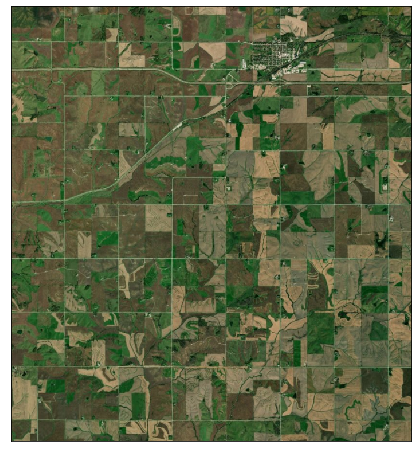

In [0]:
matplotlib.rcParams['figure.figsize'] = (35,35) 
generate_pt_viz(test_turb_point['ylat'],  test_turb_point['xlong'], 4)
plt.show()

In [0]:
test_med_turb_point = med_cap_turbines.iloc[0]
test_med_turb_point

p_cap      18.430000
p_tnum    194.000000
xlong    -118.359026
ylat       35.083407
Name: 251 Wind, dtype: float64

<Figure size 2520x2520 with 0 Axes>

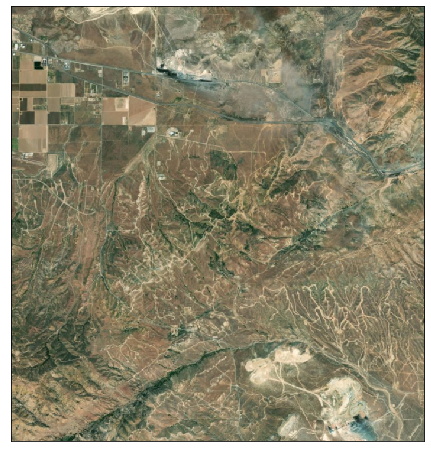

In [0]:
plt.clf()
matplotlib.rcParams['figure.figsize'] = (35,35) 
generate_pt_viz(test_med_turb_point['ylat'],  test_med_turb_point['xlong'], 4)
plt.show()

In [0]:
test_low_turb_point = low_cap_turbines.iloc[0]
test_low_turb_point

p_cap      3.00000
p_tnum     2.00000
xlong    -70.54655
ylat      41.75859
Name: AFCEE MMR Turbines, dtype: float64

<Figure size 2520x2520 with 0 Axes>

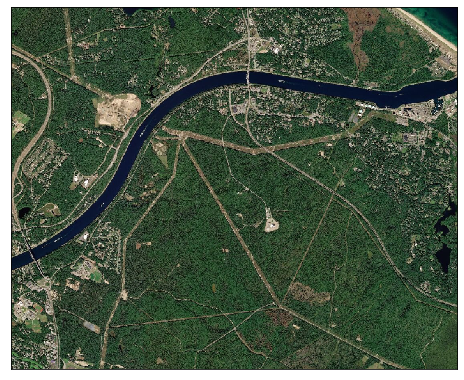

In [0]:
plt.clf()
matplotlib.rcParams['figure.figsize'] = (35,35) 
generate_pt_viz(test_low_turb_point['ylat'],  test_low_turb_point['xlong'], 2)
plt.show()

In [0]:
test_no_turb_high_pot_point = high_pot_df.iloc[1]
test_no_turb_high_pot_point

xlong   -109.223459
ylat      43.749780
Name: 1, dtype: float64

<Figure size 2520x2520 with 0 Axes>

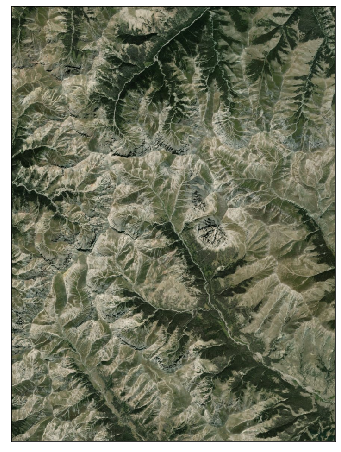

In [0]:
plt.clf()
matplotlib.rcParams['figure.figsize'] = (35,35) 
generate_pt_viz(test_no_turb_high_pot_point['ylat'], test_no_turb_high_pot_point['xlong'], 5)
plt.show()

In [0]:
test_no_turb_med_cap_point = med_pot_df.iloc[0]
test_no_turb_med_cap_point

xlong   -101.080629
ylat      43.523965
Name: 0, dtype: float64

<Figure size 2520x2520 with 0 Axes>

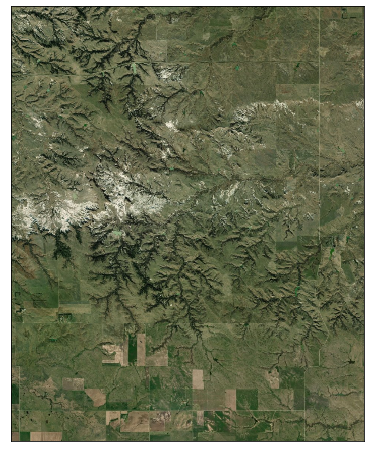

In [0]:
plt.clf()
matplotlib.rcParams['figure.figsize'] = (30,30) 
generate_pt_viz(test_no_turb_med_cap_point['ylat'], test_no_turb_med_cap_point['xlong'], 5)
plt.show()

In [0]:
test_no_turb_low_cap_point = low_pot_df.iloc[40]
test_no_turb_low_cap_point

xlong   -103.786765
ylat      48.326817
Name: 40, dtype: float64

<Figure size 2160x2160 with 0 Axes>

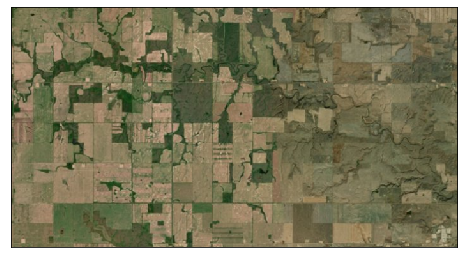

In [0]:
plt.clf()
matplotlib.rcParams['figure.figsize'] = (10,10) 
generate_pt_viz(test_no_turb_low_cap_point['ylat'], test_no_turb_low_cap_point['xlong'], 3)
plt.show()

In [0]:
test_no_turb_no_pot = no_pot_df.iloc[0]
test_no_turb_no_pot

xlong   -95.657024
ylat     38.121267
Name: 0, dtype: float64

<Figure size 720x720 with 0 Axes>

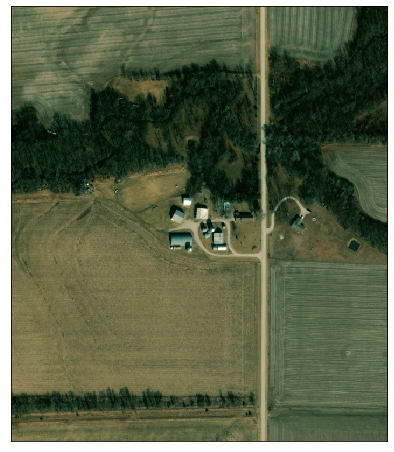

In [0]:
plt.clf()
matplotlib.rcParams['figure.figsize'] = (1,1) 
generate_pt_viz(test_no_turb_no_pot['ylat'], test_no_turb_no_pot['xlong'], .2)
plt.show()

## Training Set Generation/Automation 

### Helpers 

In [0]:
def save_visualization(directory, class_label):
  save_loc = directory + class_label + ".jpg"
  plt.savefig(save_loc, transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi = 500.0,)
  plt.clf()



In [0]:
def img_plotter(lat, lon, buffer, directory, name, fig_sz=8):
  generate_pt_viz(lat, lon, buffer, fig_sz)
  save_visualization(directory, name)

In [0]:
def set_generator(dataframe, buffer, dir, label, fig_sz=8, counter=0):
  counter = counter
  for row in dataframe.itertuples():
    counter+= 1
    img_name = label + "_" + str(counter)
    img_plotter(lat=row.ylat, lon=row.xlong, buffer=buffer, directory=dir, fig_sz=fig_sz, name=img_name)

In [0]:
train_test_split = .95

def split_frame(df, split, seed=29):
  train=df.sample(frac=split, random_state=seed) #random state is a seed value
  test=df.drop(train.index)
  return train, test


### Pipeline 

#### Class: Turbines, Low Capacity 

In [0]:
import numpy as np

In [0]:
#low_cap_turbines
np.random.seed(56)
low_cap_sample = low_cap_turbines.sample(n=200)
train_low_cap_turbines, test_low_cap_turbines = split_frame(low_cap_sample, train_test_split)
save_loc1 = data_dir + "/train/turbines_low_capacity/"
save_loc2 = data_dir + "/test/turbines_low_capacity/"

***Training Set***

In [0]:
matplotlib.rcParams['figure.figsize'] = (35,35) 
set_generator(train_low_cap_turbines, 2, save_loc1, "train_low_cap")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

***Test Images***

In [0]:
set_generator(test_low_cap_turbines, 2, save_loc2, "test_lc")

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

#### Class: Turbines, Medium Capacity

In [0]:
#med_cap_turbines
np.random.seed(38)
med_cap_sample = med_cap_turbines.sample(n=250)
train_med_cap_turbines, test_med_cap_turbines = split_frame(med_cap_sample, train_test_split)
save_loc1 = data_dir + "/train/turbines_medium_capacity/"
save_loc2 = data_dir + "/test/turbines_medium_capacity/"



***Training Set***

In [0]:
matplotlib.rcParams['figure.figsize'] = (35,35) 
set_generator(train_med_cap_turbines, 4, save_loc1, "train_med_cap")

***Test Images***

In [0]:
set_generator(test_med_cap_turbines, 4, save_loc2, "test_mc")

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

#### Class: Turbines, High Capacity

In [0]:
#high_cap_turbines
np.random.seed(29)
high_cap_sample = high_cap_turbines.sample(n=175)
train_high_cap_turbines, test_high_cap_turbines = split_frame(high_cap_sample, train_test_split)
save_loc1 = data_dir + "/train/turbines_high_capacity/"
save_loc2 = data_dir + "/test/turbines_high_capacity/"

***Training Set***

In [0]:
matplotlib.rcParams['figure.figsize'] = (35,35) 
set_generator(train_high_cap_turbines, 4, save_loc1, "train_high_cap")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

***Test Images***

In [0]:
set_generator(test_high_cap_turbines, 4, save_loc2, "test_hc")

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

#### Class: No Turbines, No Capacity

In [0]:
train_no_turbines_no_cap, test_no_turbines_no_cap = split_frame(no_pot_df, train_test_split)
save_loc1 = data_dir + "/train/no_turbines_no_potential/"
save_loc2 = data_dir + "/test/no_turbines_no_potential/"

***Training Set***

In [0]:
matplotlib.rcParams['figure.figsize'] = (1,1)
set_generator(train_no_turbines_no_cap, .2, save_loc1, "train_no_turb_no_cap")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

***Test Images***

In [0]:
set_generator(test_no_turbines_no_cap, .2, save_loc2, "test_ntnc")

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

#### Class: No Turbines, Medium Potential 

In [0]:
train_no_turbines_med_cap, test_no_turbines_med_cap = split_frame(med_pot_df, train_test_split)
save_loc1 = data_dir + "/train/no_turbines_med_potential/"
save_loc2 = data_dir + "/test/no_turbines_med_potential/"

***Training Set*** 

In [0]:
matplotlib.rcParams['figure.figsize'] = (30,30) 
set_generator(train_no_turbines_med_cap, 5, save_loc1, "train_no_turb_med_cap")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

***Test Images***

In [0]:
set_generator(test_no_turbines_med_cap, 5, save_loc2, "test_ntmc")

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

#### Class: No Turbines, Low Potential 

In [0]:
train_no_turbines_low_cap, test_no_turbines_low_cap = split_frame(low_pot_df, train_test_split)
save_loc1 = data_dir + "/train/no_turbines_low_potential/"
save_loc2 = data_dir + "/test/no_turbines_low_potential/"

***Training Set*** 

In [0]:
matplotlib.rcParams['figure.figsize'] = (10,10) 
set_generator(train_no_turbines_low_cap, 3, save_loc1, "train_no_turb_low_cap")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

***Test Images***

In [0]:
set_generator(test_no_turbines_low_cap, 3, save_loc2, "test_ntlc")

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

#### Class: No Turbines, High Potential 

In [0]:
train_no_turbines_high_cap, test_no_turbines_high_cap = split_frame(high_pot_df, train_test_split)
save_loc1 = data_dir + "/train/no_turbines_high_potential/"
save_loc2 = data_dir + "/test/no_turbines_high_potential/"

***Training Set*** 

In [0]:
matplotlib.rcParams['figure.figsize'] = (35,35)
set_generator(train_no_turbines_high_cap, 5, save_loc1, "train_no_turb_high_cap")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

***Test Images***

In [0]:
set_generator(test_no_turbines_high_cap, 5, save_loc2, "test_nthc")

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [0]:

def crop(directory):
  left = 155
  top = 65
  right = 360
  bottom = 270
  for filename in os.listdir(directory):
    img = Image.open(filename)
    cropped1 = img.crop((left, top, right, bottom)) 
    cropped1.save(filename + '_cropped.jpg', "JPG", quality=100)
    cropped2 = img.crop((left, top, right, bottom))
    cropped2.save(filename + '_cropped.jpg', "JPG", quality=100)


        fullpath = os.path.join(path,item)         #corrected
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            #f, e = os.path.splitext(fullpath)
            imCrop = im.crop((left, top, right, bottom)) #corrected
            imCrop.save(f + 'cropped.jpg', "JPG", quality=100)